In [1]:
!mkdir results

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

Data Preperation

In [4]:
gdf_urban_core_gu = pd.read_csv('/content/gdf_urban_core_gu.csv')
gdf_urban_core_gu= gdf_urban_core_gu.drop(['Unnamed: 0'], axis=1)
#gdf_urban_core_gu

In [5]:
idx = pd.date_range('2018-04-01 00:00:00','2018-04-30 23:55:00',freq='5min')
idx = idx.astype('str')

In [6]:
ex_core=gdf_urban_core_gu[idx.to_list()]
ex_core=ex_core.T
ex_core=ex_core.reset_index()
ex_core=ex_core.drop(['index'],axis=1)
ex_core=ex_core.T
ex_core

,0,1,2,3,4,5,6,7,8,9,...,8630,8631,8632,8633,8634,8635,8636,8637,8638,8639
0,49.39,49.74,48.69,49.04,50.71,49.46,49.06,50.26,50.86,50.31,...,49.58,48.15,48.96,49.07,49.03,48.96,49.44,48.72,49.80,49.58
1,53.34,52.38,53.20,53.53,52.62,54.08,53.13,52.49,53.36,52.85,...,51.13,51.34,51.28,51.90,51.91,50.70,50.95,51.55,52.99,52.20
2,39.47,39.22,38.84,34.21,44.50,38.28,37.69,50.92,37.50,48.58,...,35.42,36.83,36.93,36.18,35.79,34.78,35.94,36.47,34.78,35.21
3,29.02,34.66,34.49,42.51,36.78,40.59,36.67,40.97,39.80,39.69,...,29.60,32.36,32.66,33.09,33.77,30.38,48.38,36.53,33.29,33.24
4,48.33,46.12,50.23,45.12,51.00,46.51,49.90,55.03,51.77,48.57,...,46.60,50.99,51.81,48.02,48.25,47.16,48.07,46.30,47.90,52.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,46.22,44.86,47.40,44.94,44.18,46.87,46.87,45.86,47.14,47.03,...,40.56,40.47,40.69,39.66,41.80,41.70,40.72,37.27,42.97,41.78
300,57.24,56.30,57.34,54.87,56.96,61.61,58.06,59.61,61.87,62.79,...,55.40,56.44,58.30,55.26,56.32,57.12,55.97,58.98,57.34,60.92
301,59.56,57.49,59.51,59.44,60.52,59.21,57.35,59.83,59.72,59.11,...,39.56,42.05,36.17,45.71,43.80,47.92,49.52,52.32,50.18,57.08
302,61.14,60.25,59.74,63.45,61.89,62.80,62.03,62.90,61.98,63.94,...,61.10,58.90,59.38,59.47,62.37,59.50,61.51,59.59,60.62,61.42


In [7]:
import numpy as np

# Extract timestamp columns
timestamp_cols = ex_core.columns
timestamps_data = ex_core.loc[:, timestamp_cols].values

# Define the number of timestamps per image and number of "Link ID"s
num_timestamps_per_image = 8
num_link_ids = timestamps_data.shape[0]

# Create spatio-temporal images
num_images = timestamps_data.shape[1] - num_timestamps_per_image +1
spatio_temporal_images = np.array([
    timestamps_data[:, i:i+num_timestamps_per_image]
    for i in range(num_images)
])

# Shape of spatio_temporal_images: [num_images, num_link_ids, num_timestamps_per_image]

In [8]:
spatio_temporal_images.shape

(8633, 304, 8)

[0] train/test/val split 을 위한 input data 생성

In [9]:
temp_target =spatio_temporal_images[:, :, :4]
final_y_data = temp_target[1:]
final_y_data.shape

(8632, 304, 4)

In [10]:
final_x_data =spatio_temporal_images[:-1]
final_x_data.shape

(8632, 304, 8)

[1] Train/Test/Val split

In [11]:
from sklearn.model_selection import train_test_split

# Define the size of the test set
test_size = 0.23

# First split: Separate out the test set
X_temp, X_test_, y_temp, y_test_ = train_test_split(
    final_x_data, final_y_data, test_size=test_size, random_state=42
)

# Define the size of the validation set relative to the temporary training set
# Since we want 7% of the total data in the validation set, and we have already
# allocated 23% to the test set, we determine the validation size as follows:
# (0.07 / (1 - 0.23)) = 0.091 of the temporary training set
val_size = 0.07 / (1 - test_size)

# Second split: Separate out the validation set from the (temporary) training set
X_train_, X_val_, y_train_, y_val_ = train_test_split(
    X_temp, y_temp, test_size=val_size, random_state=42
)

In [12]:
X_train_.shape

(6041, 304, 8)

In [13]:
y_train_.shape

(6041, 304, 4)

[2] MinMaxScaling


In [14]:
from sklearn.preprocessing import MinMaxScaler    #ReLU에서 음수는 다 0으로 처리하여 MinMaxScaler 적용


# Initialize a scaler
X_scaler = MinMaxScaler()
X_scaler.fit(X_train_.reshape(-1,8))

y_scaler = MinMaxScaler()
y_scaler.fit(y_train_.reshape(-1,4))

scaled_X_train = X_scaler.transform(X_train_.reshape(-1,8)).reshape(X_train_.shape)
scaled_y_train = y_scaler.transform(y_train_.reshape(-1,4)).reshape(y_train_.shape)

scaled_X_test = X_scaler.transform(X_test_.reshape(-1,8)).reshape(X_test_.shape)
scaled_y_test = y_scaler.transform(y_test_.reshape(-1,4)).reshape(y_test_.shape)

scaled_X_val = X_scaler.transform(X_val_.reshape(-1, 8)).reshape(X_val_.shape)
scaled_y_val = y_scaler.transform(y_val_.reshape(-1, 4)).reshape(y_val_.shape)



[3] torch로 변환, partition으로 생성

In [15]:
X_train = torch.tensor(scaled_X_train, dtype=torch.float32)
y_train = torch.tensor(scaled_y_train, dtype=torch.float32)
X_train = X_train.unsqueeze(1)   # (num_images, 1, height, width) 로 num_channel = 1 추가
y_train = y_train.unsqueeze(1)

X_val = torch.tensor(scaled_X_val, dtype=torch.float32)
y_val = torch.tensor(scaled_y_val, dtype=torch.float32)
X_val = X_val.unsqueeze(1)
y_val = y_val.unsqueeze(1)

X_test = torch.tensor(scaled_X_test, dtype=torch.float32)
y_test = torch.tensor(scaled_y_test, dtype=torch.float32)
X_test = X_test.unsqueeze(1)
y_test = y_test.unsqueeze(1)

In [16]:
X_test.shape

torch.Size([1986, 1, 304, 8])

In [17]:
y_test.shape

torch.Size([1986, 1, 304, 4])

In [18]:
from torch.utils.data import TensorDataset

trainset = TensorDataset(X_train, y_train)
valset = TensorDataset(X_val, y_val)
testset = TensorDataset(X_test, y_test)

In [19]:
partition = {'train': trainset, 'val':valset, 'test':testset}

Model Code

In [20]:
cfg = {
    'Depth1' : [],
    'Depth2' : [64, 'M'],
    'Depth3' : [128, 'M', 64, 'M'],
    'Depth4' : [256, 'M', 128, 'M', 64],
}

class CNN

In [21]:
class CNN(nn.Module):

    def __init__(self, model_code, in_channels, out_dim, act, use_bn, dropout, hid_dim):
        super(CNN, self).__init__()


        if act == 'relu' :
            self.act = nn.ReLU()
        elif act == 'sigmoid' :
            self.act = nn.Sigmoid()
        elif act == 'tanh' :
            self.act = nn.Tanh()
        else :
            raise ValueError("Not a valid activation function code")



        self.layers = self._make_layers(model_code, in_channels, use_bn)     #클레스 함수명이마 클레스 property 앞에 언더바() 표시 하면 : private 함수로 밖에서 봤을 때 접근할 수 없는 함수

        dummy_input = torch.zeros(1, in_channels, 304, 8)     # 이 부분 추가 ; Maxpooling 추가될 때 마다 shape 달라지므로
        flatten_size = self._get_flattened_size(dummy_input)  # 이 부분 추가 ; Maxpooling 추가될 때 마다 shape 달라지므로

        self.classifier = nn.Sequential(nn.Linear(flatten_size, out_dim),
                                        )

    def forward(self, x):         # nn.Sequential 형태에서 x라는 input data를 자동으로 호출할 수 있음
        x = self.layers(x)
        #print("Before flatten:", x.shape)

        x = x.view(x.size(0), -1)
        #print("After flatten:", x.shape)

        x = self.classifier(x)
        x = x.view(x.size(0), 1, 304, 4)   # 이부분 추가 (마지막 output shape 변경)
        return x

    def _make_layers(self, model_code, in_channels, use_bn) :    # Sequential를 함수로 받아 사용하는 방식은 nn.Modulelist 를 대체 하는 다른 방식임
        layers = []

        if cfg[model_code] == []:
            self.is_mlp_mode = True     # MLP 모드로 전환
            return nn.Identity()

        else:
          self.is_mlp_mode = False
          for x in cfg[model_code] :
              if x == 'M':
                  layers += [nn.MaxPool2d(kernel_size =2, stride = 2)]

              else:
                  layers += [nn.Conv2d(in_channels=in_channels,
                                      out_channels = x,
                                      kernel_size=3,
                                      stride =1,
                                      padding =1) ]


                  if use_bn :
                        layers += [nn.BatchNorm2d(x)]           # 각 out_chennel 마다 정규화 됨
                  layers += [self.act]

                  in_channels = x
          return nn.Sequential(*layers)      # *layers : list에 모든 layer를 다 집어 넣고 Sequential 로 감싸줌 --> 하나의 서브모델을 생성한다고 보면 됨


    def _get_flattened_size(self, x) :        #nn.Linear(input, ) 에 자동 반영을 위해 함수 정의
        x = self.layers(x)
        return x.view(x.size(0), -1).size(1)

class MLP

In [22]:
class MLP(nn.Module):
    def __init__(self, in_shape, out_dim, hid_dim, n_layer, act, dropout, use_bn, ):
        super(MLP, self).__init__()

        # ====== Create Activation Function ====== #
        if act == 'relu':            # 코드 수정함(self.act 를 str 로 인식하여 에러나서)
            self.act = nn.ReLU()
        elif act == 'tanh':
            self.act = nn.Tanh()
        elif act == 'sigmoid':
            self.act = nn.Sigmoid()
        else:
            raise ValueError('No valid activation function selected!')

        # input_shape 예: (batch_size, channels, height, width)
        self.in_dim = in_shape[1]*in_shape[2]*in_shape[3]
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layer = n_layer
        self.act_name = act      # 코드 수정함!!(self.act 를 str 로 인식하여 에러나서)
        self.dropout = dropout
        self.use_bn = use_bn


        # ===== nn.Sequential로 layer 생성 ====== #
        layers = [
            nn.Linear(self.in_dim, hid_dim),
            self.act,
                ]
        if use_bn:
            layers.append(nn.BatchNorm1d(hid_dim))

        layers.append(nn.Dropout(dropout))

        for _ in range(n_layer - 1):
            layers.append(nn.Linear(hid_dim, hid_dim))
            layers.append(self.act)
            if use_bn:
                layers.append(nn.BatchNorm1d(hid_dim))

            layers.append(nn.Dropout(dropout))

        layers.append(nn.Linear(hid_dim, out_dim))

        self.classifier = nn.Sequential(*layers)


        # ====== Create Regularization Layer ======= #
        self.dropout = nn.Dropout(self.dropout)
        #if self.use_xavier:
        #    self.xavier_init()

    def forward(self, x):
        x= x.view(x.size(0),-1)  #batch 크기는 유지하고 1열로 펴기
        x = self.classifier(x)
        x = x.view(x.size(0), 1, 304, 4)
        return x



In [23]:
def train(net, partition, optimizer, criterion, args):
    trainloader = torch.utils.data.DataLoader(partition['train'],
                                              batch_size=args.train_batch_size,
                                              shuffle=True, num_workers=2)
    net.train()


    mae_criterion = nn.L1Loss()    #MAE 값 계산을 위해 추가


    total = 0
    train_loss = 0.0
    train_mae = 0       #MAE 초기값 설정
    batch_orig_mse = 0  #Orig_mse 초기화
    for i, data in enumerate(trainloader, 0):
        optimizer.zero_grad()

        # get the inputs
        inputs, labels = data
        #print(f"input shape: {inputs.shape}, labels.shape: {labels.shape}")
        #break
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)    # batchsize의 전체 loss 값
        total += labels.size(0)
        mae = mae_criterion(outputs, labels)
        train_mae += mae.item() * inputs.size(0)     # minibatch에 대한 mae 합 출력

        # 역정규화 상태 MSE
        if y_scaler is not None:
            # outputs, labels: tensor -> numpy (역정규화 하려면 numpy로 변환 필요)
            outputs_np = outputs.detach().cpu().numpy().reshape(-1, 4)
            labels_np = labels.detach().cpu().numpy().reshape(-1, 4)

            # 역정규화
            outputs_orig = y_scaler.inverse_transform(outputs_np).reshape(outputs.shape)
            labels_orig = y_scaler.inverse_transform(labels_np).reshape(labels.shape)

            # batch별 Orig_Mse 계산 (numpy)
            orig_loss = np.mean((outputs_orig - labels_orig)**2)
            batch_orig_mse += orig_loss.item() * inputs.size(0)


    train_loss = train_loss / total
    train_mae_loss = train_mae / total   # 전체 data에 대한 평균 mae 출력

    train_orig_loss = batch_orig_mse / total if y_scaler is not None else None


    return net, train_loss, train_orig_loss, train_mae_loss

In [24]:
def validate(net, partition, criterion, args):

    valloader = torch.utils.data.DataLoader(partition['val'],
                                            batch_size=args.test_batch_size,
                                            shuffle=False, num_workers=2)
    net.eval()

    mae_criterion = nn.L1Loss()    #MAE 값 계산을 위해 추가

    total = 0
    val_loss = 0
    batch_orig_mse = 0 # 역정규화 상태 MSE
    val_mae = 0       #MAE 초기값 설정
    val_mae_orig = 0  # 역정규화 상태 MAE

    with torch.no_grad():
        for data in valloader:
            inputs, labels = data
            inputs = inputs.cuda()
            labels = labels.cuda()
            outputs = net(inputs)

            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            total += labels.size(0)

            # 정규화된 상태 MAE
            mae = mae_criterion(outputs, labels)
            val_mae += mae.item() * inputs.size(0)     # minibatch에 대한 mae 합 출력


            # 역정규화 상태 MAE
            if y_scaler is not None:
                # outputs, labels: tensor -> numpy (역정규화 하려면 numpy로 변환 필요)
                outputs_np = outputs.detach().cpu().numpy().reshape(-1, 4)
                labels_np = labels.detach().cpu().numpy().reshape(-1, 4)

                # 역정규화
                outputs_orig = y_scaler.inverse_transform(outputs_np).reshape(outputs.shape)
                labels_orig = y_scaler.inverse_transform(labels_np).reshape(labels.shape)

                # batch별 MAE 계산 (numpy)
                batch_mae = np.mean(np.abs(outputs_orig - labels_orig))
                val_mae_orig += batch_mae * inputs.size(0)
                orig_loss = np.mean((outputs_orig - labels_orig)**2)
                batch_orig_mse += orig_loss.item() * inputs.size(0)


        val_loss = val_loss / total
        val_orig_loss = batch_orig_mse / total if y_scaler is not None else None
        val_mae_loss = val_mae / total
        val_mae_orig_loss = val_mae_orig / total if y_scaler is not None else None


    return val_loss, val_orig_loss, val_mae_loss, val_mae_orig_loss

In [25]:
def test(net, partition, args):

    testloader = torch.utils.data.DataLoader(partition['test'],
                                             batch_size=args.test_batch_size,
                                             shuffle=False, num_workers=2)
    net.eval()

    mse_criterion = nn.MSELoss()    # test 에서 손실함수 정의
    mae_criterion = nn.L1Loss()     # 손실함수 2 정의

    test_mse = 0
    batch_orig_mse = 0 # 역정규화 상태 MSE
    test_mae = 0
    test_mae_orig = 0  # 역정규화 상태 MAE

    total = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs = inputs.cuda()
            labels = labels.cuda()

            outputs = net(inputs)

            mse = mse_criterion(outputs, labels)
            mae = mae_criterion(outputs, labels)

            total += labels.size(0)
            test_mse += mse.item() * inputs.size(0)       #inputs.sie(0) 는 batch_size를 나타냄
            test_mae += mae.item() * inputs.size(0)

               # 역정규화 상태 MAE
            if y_scaler is not None:
                # outputs, labels: tensor -> numpy (역정규화 하려면 numpy로 변환 필요)
                outputs_np = outputs.detach().cpu().numpy().reshape(-1, 4)
                labels_np = labels.detach().cpu().numpy().reshape(-1, 4)

                # 역정규화
                outputs_orig = y_scaler.inverse_transform(outputs_np).reshape(outputs.shape)
                labels_orig = y_scaler.inverse_transform(labels_np).reshape(labels.shape)

                # batch별 MAE 계산 (numpy)
                batch_mae = np.mean(np.abs(outputs_orig - labels_orig))
                test_mae_orig += batch_mae * inputs.size(0)
                orig_loss = np.mean((outputs_orig - labels_orig)**2)
                batch_orig_mse += orig_loss.item() * inputs.size(0)

        test_mse_loss = test_mse / total
        test_orig_loss = batch_orig_mse / total if y_scaler is not None else None
        test_mae_loss = test_mae / total
        test_mae_orig_loss = test_mae_orig / total if y_scaler is not None else None

    return test_mse_loss, test_orig_loss, test_mae_loss, test_mae_orig_loss

Early Stopping

In [26]:
# 간단한 EarlyStopping 클래스
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:     #best_loss보다 min_delta만큼 개선되지 않으면 count함
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

Experiment

In [27]:
def experiment(partition, args):

    trainloader = torch.utils.data.DataLoader(
        partition['train'],
        batch_size=args.train_batch_size,
        shuffle=True,
        num_workers=2
          )

    sample_inputs, _ = next(iter(trainloader))    # 1번째 미니 배치 추출
    sample_inputs = sample_inputs.cuda()
    in_shape = sample_inputs.shape                # 그의 shape


    if args.model_type == 'CNN':

        net = CNN(model_code = args.model_code,
                  in_channels = args.in_channels,
                  out_dim = args.out_dim,
                  act = args.act,
                  use_bn= args.use_bn,
                  dropout = args.dropout,
                  hid_dim = args.hid_dim)

    elif args.model_type == 'MLP':
        net = MLP(
            in_shape=in_shape,
            out_dim=args.out_dim,
            hid_dim=args.hid_dim,
            n_layer=args.n_layer,
            act=args.act,
            dropout=args.dropout,
            use_bn=args.use_bn
        )
    else:
        raise ValueError(f"Invalid model_type: {args.model_type}")

    net.cuda()

    criterion = nn.MSELoss()  #회귀용 손실함수 사용
    if args.optim == 'SGD':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')


    # EarlyStopping 인스턴스 생성
    early_stopping = EarlyStopping(patience=7, min_delta=0.00001) if args.use_early_stopping else None


    # ReduceLROnPlateau 스케줄러 설정
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=3, factor=0.1, min_lr=1e-6,
        threshold=1e-3, threshold_mode='abs') if args.use_scheduler else None                   #threshold는 val_loss가 best_loss(자동 저장됨)보다 threshold 만큼 감소하지 않고 3epoh 이상이면 lr감소함 (early_stopping의 min_delta와 동일한 역할)

    # ===== List for epoch-wise data ====== #
    train_losses = []
    val_losses = []
    train_mae_losses = []
    val_mae_losses = []
    val_mae_orig_losses = []
    # ===================================== #
    best_metric = float('inf')

    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        net, train_loss, train_orig_loss, train_mae_loss = train(net, partition, optimizer, criterion, args)
        val_loss, val_orig_loss, val_mae_loss, val_mae_orig_loss = validate(net, partition, criterion, args)
        te = time.time()

        #====schduler에 val_loss 전달====
        if args.use_scheduler:
            scheduler.step(val_loss)
        #====early stopping 에 val_loss 전달====
        if args.use_early_stopping:
            early_stopping(val_loss)
            if early_stopping.early_stop :
                  print("Early stopping triggered!")
                  break


        # ====== Add Epoch Data ====== #
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_mae_losses.append(train_mae_loss)
        val_mae_losses.append(val_mae_loss)
        val_mae_orig_losses.append(val_mae_orig_loss)
        # ============================ #

        setting = deepcopy(vars(args))
        del setting['epoch']
        hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
        os.makedirs('./checkpoints', exist_ok=True)                     #최초 모델 저장 경로(폴더) 만들기
        model_path = f'./checkpoints/{args.exp_name}-{hash_key}.pth'    #setting에 따라 model_path 저장 경로 설정

        if val_mae_orig_loss < best_metric:
            best_metric = val_mae_orig_loss
            torch.save(net.state_dict(), model_path)                    # 실험 별 가장 좋은 성능 모델 파라미터를 저장함

        current_lr = scheduler.get_last_lr()[0] if args.use_scheduler else args.lr
        print('Epoch {}, Loss(train/val) {:2.4f}/{:2.4f}, MAELoss(train/val) {:2.4f}/{:2.4f}, MAE_origLoss(val) {:2.4f}. Took {:2.2f} sec, Current LR {:2.6f}'.format(epoch, train_loss, val_loss, train_mae_loss, val_mae_loss, val_mae_orig_loss, te-ts, current_lr))

    test_loss, test_orig_loss, test_mae_loss, test_mae_orig_loss = test(net, partition, args)

    # ======= Add Result to Dictionary ======= #
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_mae_losses'] = train_mae_losses
    result['val_mae_losses'] = val_mae_losses
    result['val_mae_orig_losses'] = val_mae_orig_losses
    result['train_mse'] = train_loss   #마지막 train_loss
    result['val_mse'] = val_loss       #마지막 val_loss
    result['test_mse'] = test_loss     #a마지막 test_loss
    result['train_mae'] = train_mae_loss   #마지막 train_loss
    result['val_mae'] = val_mae_loss       #마지막 val_loss
    result['test_mae'] = test_mae_loss     #마지막 test_loss
    result['train_orig_loss'] = train_orig_loss
    result['test_orig_loss'] = test_orig_loss        # 마지막 원래 범위 test mse
    result['val_mae_orig_loss'] = val_mae_orig_loss  # 마지막 원래 범위 val mae 값
    result['test_mae_orig_loss'] = test_mae_orig_loss # 마지막 원래 범위 test mae 값

    return vars(args), result
    # ===================================== #

Save and Load experiment result

In [28]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def convert_np(obj):
    """JSON이 직렬화할 수 있도록 NumPy 타입을 변환"""
    if isinstance(obj, (np.integer, np.int32, np.int64)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, (np.bool_)):
        return bool(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    return str(obj)


def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]        # setting이 arguments 딕셔너리이므로 이에 대한 값을 hash 6자리 형태로 변환
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)         # result 딕셔너리에 setting 값 딕셔너리 합침 (.update() 함수)
    result['hash_key'] = hash_key  # result에 has_key 추가

    with open(filename, 'w') as f:
        json.dump(result, f, default=convert_np, indent=2)      # 파일 f에 a의 데이터를 덮어씌워 줘라, 즉 result 딕셔너리와 settig 값 딕셔너리를 해당 이름(filename)으로 저장한 파일 생성함

    return hash_key      # 추가

def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]   # dir_path 디렉토리 하위에 있는 파일(isfile) 중, 이름에 .json이라는 문자열이 포함된 파일만 리스트로 반환
    list_result = []
    for filename in filenames:
        if exp_name in filename:     # 여기서 filename 에 exp_name의 문자열이 일부라도 포함되어 있는 파일을 가져옴
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df

Visualization (1)

In [29]:
def plot_mse_loss(var1, var2, df, order=None):
    if order:
      df[var1] = pd.Categorical(df[var1], categories=order, ordered=True)
    fig, ax = plt.subplots(1, 4)
    fig.set_size_inches(15, 4)
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    sns.barplot(x=var1, y='train_mse', hue=var2, data=df, ax=ax[0], order=order)
    sns.barplot(x=var1, y='val_mse', hue=var2, data=df, ax=ax[1], order=order)
    sns.barplot(x=var1, y='test_mse', hue=var2, data=df, ax=ax[2], order=order)
    sns.barplot(x=var1, y='test_orig_loss', hue=name_var2, data=df, ax=ax[3], order=order)

    ax[0].set_title('Train MSE Loss')
    ax[1].set_title('Validation MSE Loss')
    ax[2].set_title('Test MSE Loss')
    ax[3].set_title('Test Orig MSE Loss')

    ax[0].get_legend().remove()
    ax[1].get_legend().remove()
    ax[2].get_legend().remove()
    ax[3].legend(loc='center left', bbox_to_anchor=(1.05, 0.5), title=var2)

    plt.tight_layout()

def plot_mae_loss(var1, var2, df, order=None):
    if order:
      df[var1] = pd.Categorical(df[var1], categories=order, ordered=True)
    fig, ax = plt.subplots(1, 4)
    fig.set_size_inches(15, 4)
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    sns.barplot(x=var1, y='train_mae', hue=var2, data=df, ax=ax[0], order=order)
    sns.barplot(x=var1, y='val_mae', hue=var2, data=df, ax=ax[1], order=order)
    sns.barplot(x=var1, y='test_mae', hue=var2, data=df, ax=ax[2], order=order)
    sns.barplot(x=var1, y='test_mae_orig_loss', hue=name_var2, data=df, ax=ax[3], order=order)

    ax[0].set_title('Train MAE Loss')
    ax[1].set_title('Validation MAE Loss')
    ax[2].set_title('Test MAE Loss')
    ax[3].set_title('Test Orig MAE Loss')

    ax[0].get_legend().remove()
    ax[1].get_legend().remove()
    ax[2].get_legend().remove()
    ax[3].legend(loc='center left', bbox_to_anchor=(1.05, 0.5), title=var2)

    plt.tight_layout()


Visualization (2)

In [30]:
def plot_loss_variation(var1, var2, df, order_var1=None, order_var2=None,  **kwargs ) :


  list_v1 = df[var1].unique()
  list_v2 = df[var2].unique()
  list_data = []

  for value1 in list_v1:
      for value2 in list_v2:
          row = df.loc[df[var1]==value1]
          row = row.loc[row[var2]==value2]

          train_losses = list(row.train_losses)[0]
          val_losses = list(row.val_losses)[0]
          test_mse = list(row.test_mse)[0]

          for epoch, train_loss in enumerate(train_losses):
              list_data.append({'type':'train', 'loss':train_loss, 'testloss': test_mse, 'epoch':epoch, var1:value1, var2:value2})
          for epoch, val_loss in enumerate(val_losses):
              list_data.append({'type':'val', 'loss':val_loss, 'testloss': test_mse,'epoch':epoch, var1:value1, var2:value2})

  df = pd.DataFrame(list_data)
    # 순서 지정
  if order_var1:
      df[var1] = pd.Categorical(df[var1], categories=order_var1, ordered=True)
  if order_var2:
      df[var2] = pd.Categorical(df[var2], categories=order_var2, ordered=True)

  g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)  # FaceGrid : 그림이 그려질 grid 만듦
  g = g.map(plt.plot, 'epoch', 'loss', marker='.') # 각 서브플랏에 들어갈 x, y

  def show_MaeLoss(x, y, metric, **kwargs):
      plt.scatter(x, y, alpha=0.3, s=1)    # 이부분은 transform=plt.gca().TrnasAxes 여기서 활용하기 위함임. 서브플랏을 기준으로 좌표계를 변경하는 것으로 서브플롯을 분명히 해주기 위해 넣은 것임. 하지만 없어도 돌아감
      metric = "Test Loss: {:1.4f}".format(list(metric.values)[0])
      plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
  g = g.map(show_MaeLoss, 'epoch', 'loss', 'testloss')   # 'show_acc 함수에 'epoch' ,'Acc', 'test_acc' 값을 넣은 것을 호출(plot함)

  g.add_legend()
  g.fig.suptitle('Train MSELoss vs Val MSELoss')
  plt.subplots_adjust(top=0.89)


def plot_mae_loss_variation(var1, var2, df, order_var1=None, order_var2=None,  **kwargs ) :
    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[row[var2]==value2]

            train_mae_loss = list(row.train_mae_losses)[0]
            val_mae_loss = list(row.val_mae_losses)[0]    #'val_mae_orig_losses
            test_mae = list(row.test_mae)[0]         #'test_mae_orig_losses

            for epoch, train_loss in enumerate(train_mae_loss):
                list_data.append({'type':'train', 'MaeLoss':train_loss, 'test_MaeLoss':test_mae, 'epoch':epoch, var1:value1, var2:value2})    #test_acc는 10개 epoch에서 1개의 값으로 동일함
            for epoch, val_loss in enumerate(val_mae_loss):
                list_data.append({'type':'val', 'MaeLoss':val_loss, 'test_MaeLoss':test_mae, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    # 순서 지정
    if order_var1:
        df[var1] = pd.Categorical(df[var1], categories=order_var1, ordered=True)
    if order_var2:
        df[var2] = pd.Categorical(df[var2], categories=order_var2, ordered=True)

    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
    g = g.map(plt.plot, 'epoch', 'MaeLoss', marker='.')

    def show_MaeLoss(x, y, metric, **kwargs):
          plt.scatter(x, y, alpha=0.3, s=1)
          metric = "Test MaeLoss: {:1.4f}".format(list(metric.values)[0])
          plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))

    g = g.map(show_MaeLoss, 'epoch', 'MaeLoss', 'test_MaeLoss')   # 'show_acc 함수에 'epoch' ,'Acc', 'test_acc' 값을 넣은 것을 호출(plot함)

    g.add_legend()
    g.fig.suptitle('Train MaeLoss vs Val MaeLoss')
    plt.subplots_adjust(top=0.89)

VIsualization (3)

In [31]:
# val_mae_loss와 val_orig_mae_loss 같이 표기
def plot_mae_loss_variation_add(var1, var2, df, order_var1=None, order_var2=None,  **kwargs ) :
    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[row[var2]==value2]

            train_mae_loss = list(row.train_mae_losses)[0]
            val_mae_loss = list(row.val_mae_losses)[0]
            val_mae_orig_loss = list(row.val_mae_orig_losses)[0]    #'val_mae_orig_losses
            test_orig_mae = list(row.test_mae_orig_loss)[0]         #'test_mae_orig_losses

            for epoch, train_loss in enumerate(train_mae_loss):
                list_data.append({'type':'train', 'MaeLoss':train_loss, 'test_orig_MaeLoss':test_orig_mae, 'epoch':epoch, var1:value1, var2:value2})    #test_acc는 10개 epoch에서 1개의 값으로 동일함
            for epoch, val_loss in enumerate(val_mae_loss):
                list_data.append({'type':'val', 'MaeLoss':val_loss, 'test_orig_MaeLoss':test_orig_mae, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_orig_loss in enumerate(val_mae_orig_loss):
                list_data.append({'type':'val_orig', 'MaeLoss':val_orig_loss, 'test_orig_MaeLoss':test_orig_mae, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    # 순서 지정
    if order_var1:
        df[var1] = pd.Categorical(df[var1], categories=order_var1, ordered=True)
    if order_var2:
        df[var2] = pd.Categorical(df[var2], categories=order_var2, ordered=True)

    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
    g = g.map(plt.plot, 'epoch', 'MaeLoss', marker='.')

    def show_MaeLoss(x, y, metric, **kwargs):
          plt.scatter(x, y, alpha=0.3, s=1)
          metric = "Test Orig MaeLoss: {:1.3f}".format(list(metric.values)[0])
          plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))

    g = g.map(show_MaeLoss, 'epoch', 'MaeLoss', 'test_orig_MaeLoss')   # 'show_acc 함수에 'epoch' ,'Acc', 'test_acc' 값을 넣은 것을 호출(plot함)

    g.add_legend()
    g.fig.suptitle('Train MaeLoss vs Val MaeLoss vs Val Orig MaeLoss')
    plt.subplots_adjust(top=0.89)


Experiment 401
- model_type : MLP
- n_layer(5) / hid_dim(2048)

In [32]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp401_test"  # n_layer 와 hid_dim 을 바꾼 실험을 해서 파일이름 이렇게 설정함

# ====== Model ====== #
args.model_type = 'MLP'
args.n_layer = 5
#args.in_channels = 1
args.out_dim = 304 * 4    #link 수 * timestamp
args.hid_dim = 2048
args.act = 'relu'

# ====== Regularization ======= #
args.l2 = 0.0001
args.use_bn = True
args.dropout = 0.2

# ====== Optimizer & Training ====== #
args.optim = 'Adam' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0001
args.epoch = 100

args.use_early_stopping = True
args.use_scheduler = True

args.train_batch_size = 256
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'n_layer'
name_var2 = 'hid_dim'
list_var1 = [5, 10, 50]
list_var2 = [256, 512, 1024, 2048]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)

        setting, result = experiment(partition, deepcopy(args))
        hash_key =  save_exp_result(setting, result)

Namespace(exp_name='exp401_test', model_type='MLP', n_layer=5, out_dim=1216, hid_dim=256, act='relu', l2=0.0001, use_bn=True, dropout=0.2, optim='Adam', lr=0.0001, epoch=100, use_early_stopping=True, use_scheduler=True, train_batch_size=256, test_batch_size=1024)
Epoch 0, Loss(train/val) 0.4785/0.1196, MAELoss(train/val) 0.5429/0.2874, MAE_origLoss(val) 27.7862. Took 1.35 sec, Current LR 0.000100
Epoch 1, Loss(train/val) 0.4091/0.1439, MAELoss(train/val) 0.4978/0.3051, MAE_origLoss(val) 29.4963. Took 0.64 sec, Current LR 0.000100
Epoch 2, Loss(train/val) 0.3189/0.1415, MAELoss(train/val) 0.4372/0.3059, MAE_origLoss(val) 29.5701. Took 0.64 sec, Current LR 0.000100
Epoch 3, Loss(train/val) 0.2398/0.1217, MAELoss(train/val) 0.3806/0.2874, MAE_origLoss(val) 27.7796. Took 0.66 sec, Current LR 0.000100
Epoch 4, Loss(train/val) 0.1927/0.0915, MAELoss(train/val) 0.3449/0.2608, MAE_origLoss(val) 25.2147. Took 0.63 sec, Current LR 0.000100
Epoch 5, Loss(train/val) 0.1693/0.0844, MAELoss(train/va

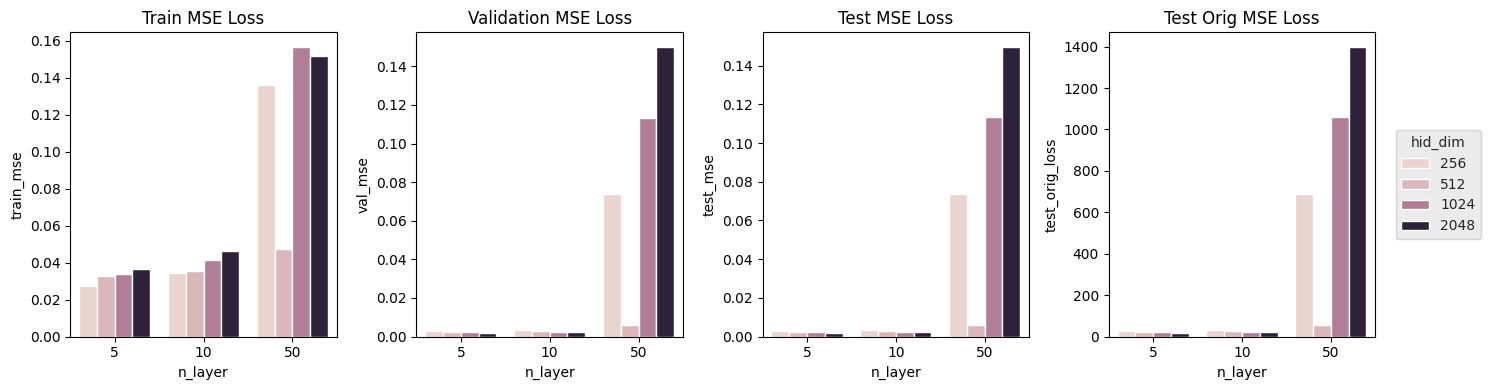

In [33]:
exp401 = load_exp_result('exp401')
var1 = 'n_layer'
var2 = 'hid_dim'
plot_mse_loss(var1, var2, exp401)

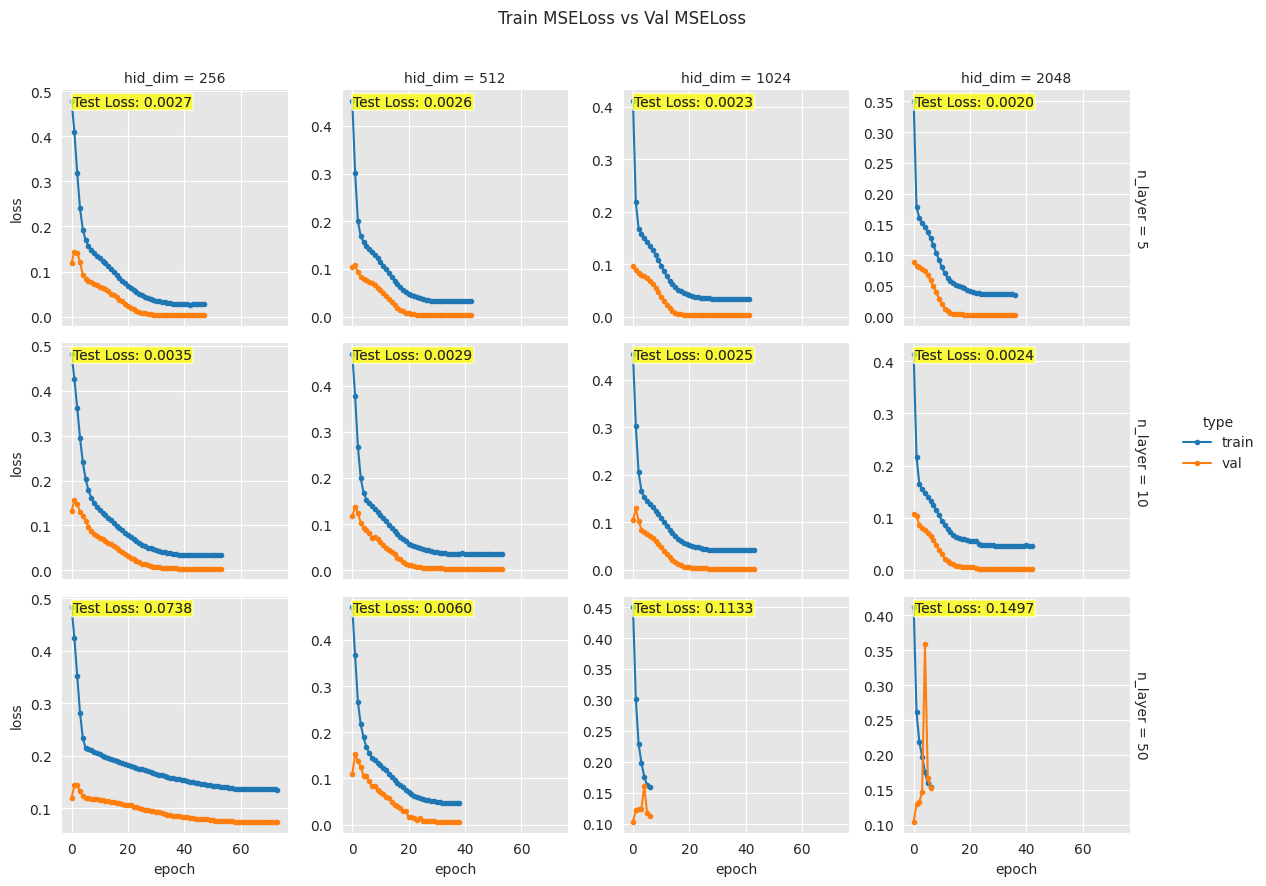

In [34]:
plot_loss_variation(var2, var1, exp401)

Experiment 402

- model_type : MLP
- Best performance : lr(0.01) / dropout(0.2)

In [35]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp402_test"

# ====== Model ====== #
args.model_type = 'MLP'
args.n_layer = 5
#args.in_channels = 1
args.out_dim = 304 * 4    #link 수 * timestamp
args.hid_dim = 2048
args.act = 'relu'

# ====== Regularization ======= #
args.l2 = 0.0001
args.use_bn = True
args.dropout = 0.2

# ====== Optimizer & Training ====== #
args.optim = 'Adam' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.01
args.epoch = 100

args.use_early_stopping = True
args.use_scheduler = True

args.train_batch_size = 256
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'lr'
name_var2 = 'dropout'
list_var1 = [0.01, 0.001, 0.0001]
list_var2 = [0.2, 0.3, 0.4]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)

        setting, result = experiment(partition, deepcopy(args))
        hash_key =  save_exp_result(setting, result)

Namespace(exp_name='exp402_test', model_type='MLP', n_layer=5, out_dim=1216, hid_dim=2048, act='relu', l2=0.0001, use_bn=True, dropout=0.2, optim='Adam', lr=0.01, epoch=100, use_early_stopping=True, use_scheduler=True, train_batch_size=256, test_batch_size=1024)
Epoch 0, Loss(train/val) 3.6091/12.4365, MAELoss(train/val) 1.2601/2.3839, MAE_origLoss(val) 230.4561. Took 1.05 sec, Current LR 0.010000
Epoch 1, Loss(train/val) 0.4511/0.0777, MAELoss(train/val) 0.5161/0.2195, MAE_origLoss(val) 21.2224. Took 0.96 sec, Current LR 0.010000
Epoch 2, Loss(train/val) 0.2435/0.0606, MAELoss(train/val) 0.3789/0.2020, MAE_origLoss(val) 19.5295. Took 0.94 sec, Current LR 0.010000
Epoch 3, Loss(train/val) 0.1910/0.1139, MAELoss(train/val) 0.3338/0.2828, MAE_origLoss(val) 27.3345. Took 1.13 sec, Current LR 0.010000
Epoch 4, Loss(train/val) 0.1457/0.0420, MAELoss(train/val) 0.2926/0.1648, MAE_origLoss(val) 15.9353. Took 1.36 sec, Current LR 0.010000
Epoch 5, Loss(train/val) 0.1062/0.0219, MAELoss(train/v

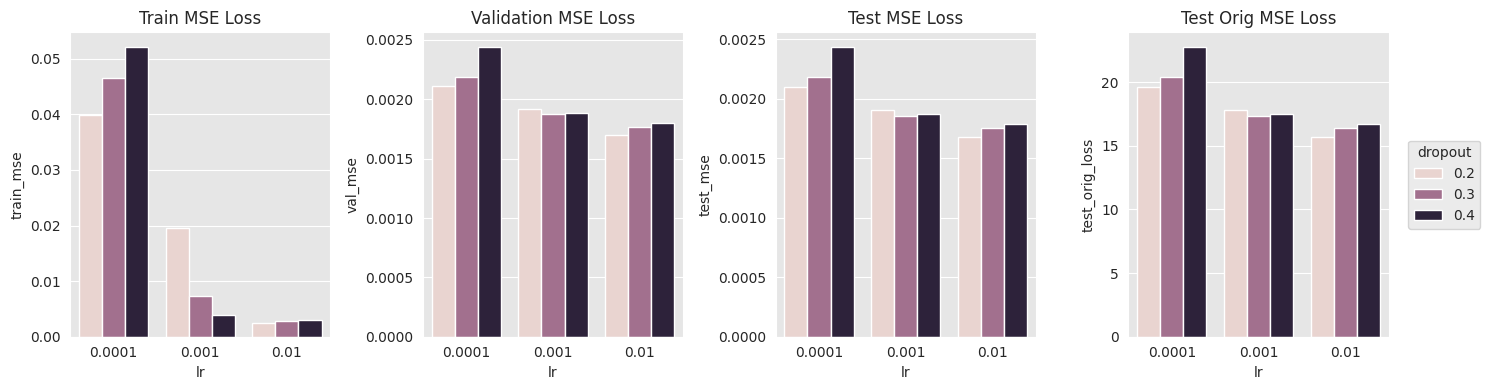

In [37]:
exp402 = load_exp_result('exp402')
var1 = name_var1
var2 = name_var2
plot_mse_loss(var1, var2, exp402)

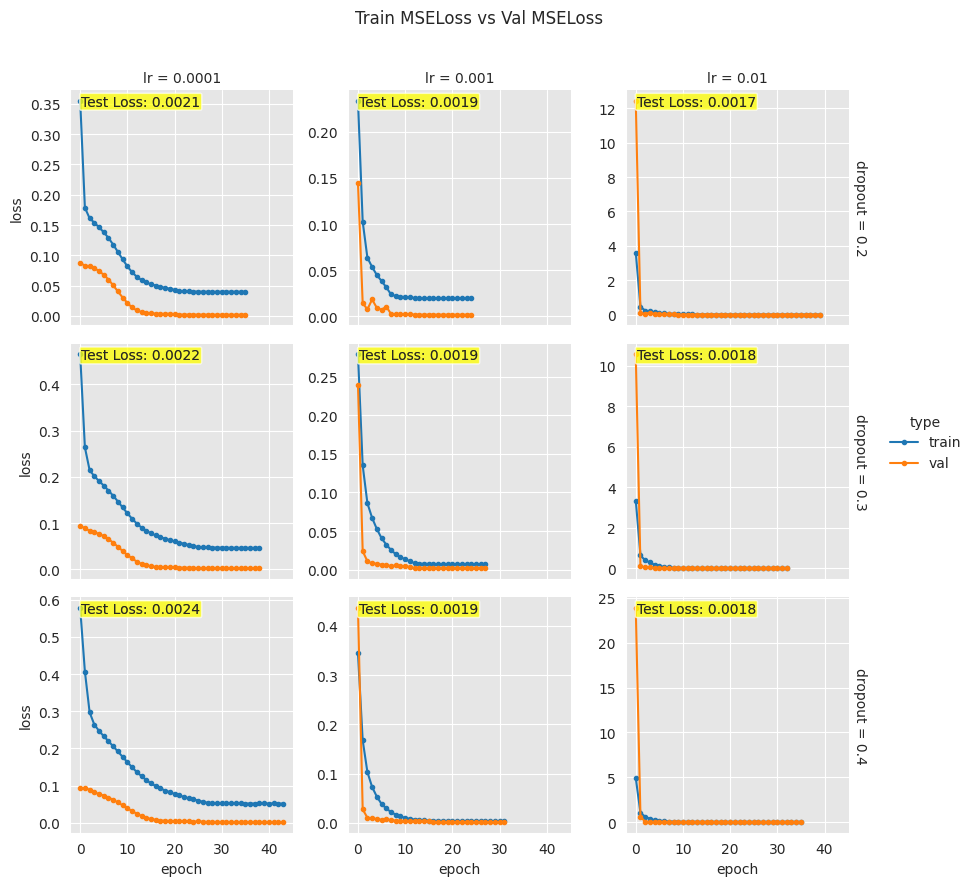

In [39]:
plot_loss_variation(var1, var2, exp402)

Experiment 403

- model_type : MLP
- Best performance : l2(0.0001) / use_bn(True)

In [40]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp403_test"

# ====== Model ====== #
args.model_type = 'MLP'
args.n_layer = 5
#args.in_channels = 1
args.out_dim = 304 * 4    #link 수 * timestamp
args.hid_dim = 2048
args.act = 'relu'

# ====== Regularization ======= #
args.l2 = 0.0001
args.use_bn = True
args.dropout = 0.2

# ====== Optimizer & Training ====== #
args.optim = 'Adam' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.01
args.epoch = 100

args.use_early_stopping = True
args.use_scheduler = True

args.train_batch_size = 256
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'l2'
name_var2 = 'use_bn'
list_var1 = [0.01, 0.001, 0.0001, 0.00001]
list_var2 = [True, False]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)

        setting, result = experiment(partition, deepcopy(args))
        hash_key =  save_exp_result(setting, result)

Namespace(exp_name='exp403_test', model_type='MLP', n_layer=5, out_dim=1216, hid_dim=2048, act='relu', l2=0.01, use_bn=True, dropout=0.2, optim='Adam', lr=0.01, epoch=100, use_early_stopping=True, use_scheduler=True, train_batch_size=256, test_batch_size=1024)
Epoch 0, Loss(train/val) 4.9070/0.2444, MAELoss(train/val) 1.3257/0.4209, MAE_origLoss(val) 40.6900. Took 1.39 sec, Current LR 0.010000
Epoch 1, Loss(train/val) 0.2022/0.0445, MAELoss(train/val) 0.3150/0.1802, MAE_origLoss(val) 17.4243. Took 1.20 sec, Current LR 0.010000
Epoch 2, Loss(train/val) 0.0394/0.0368, MAELoss(train/val) 0.1733/0.1695, MAE_origLoss(val) 16.3892. Took 0.94 sec, Current LR 0.010000
Epoch 3, Loss(train/val) 0.0367/0.0395, MAELoss(train/val) 0.1725/0.1756, MAE_origLoss(val) 16.9704. Took 0.97 sec, Current LR 0.010000
Epoch 4, Loss(train/val) 0.0354/0.0369, MAELoss(train/val) 0.1710/0.1691, MAE_origLoss(val) 16.3421. Took 0.96 sec, Current LR 0.010000
Epoch 5, Loss(train/val) 0.0342/0.0336, MAELoss(train/val) 

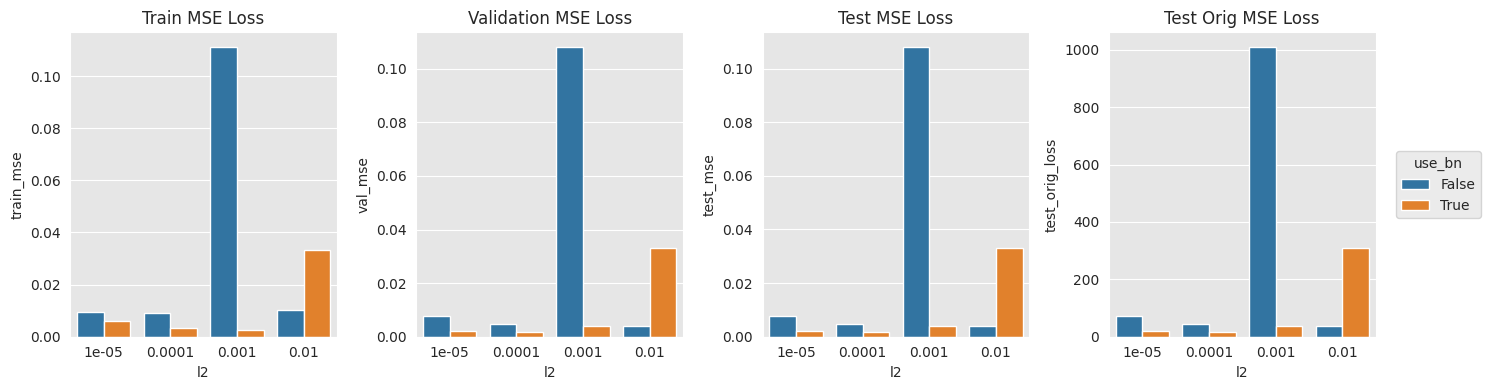

In [41]:
exp403 = load_exp_result('exp403')
var1 = name_var1
var2 = name_var2
plot_mse_loss(var1, var2, exp403)

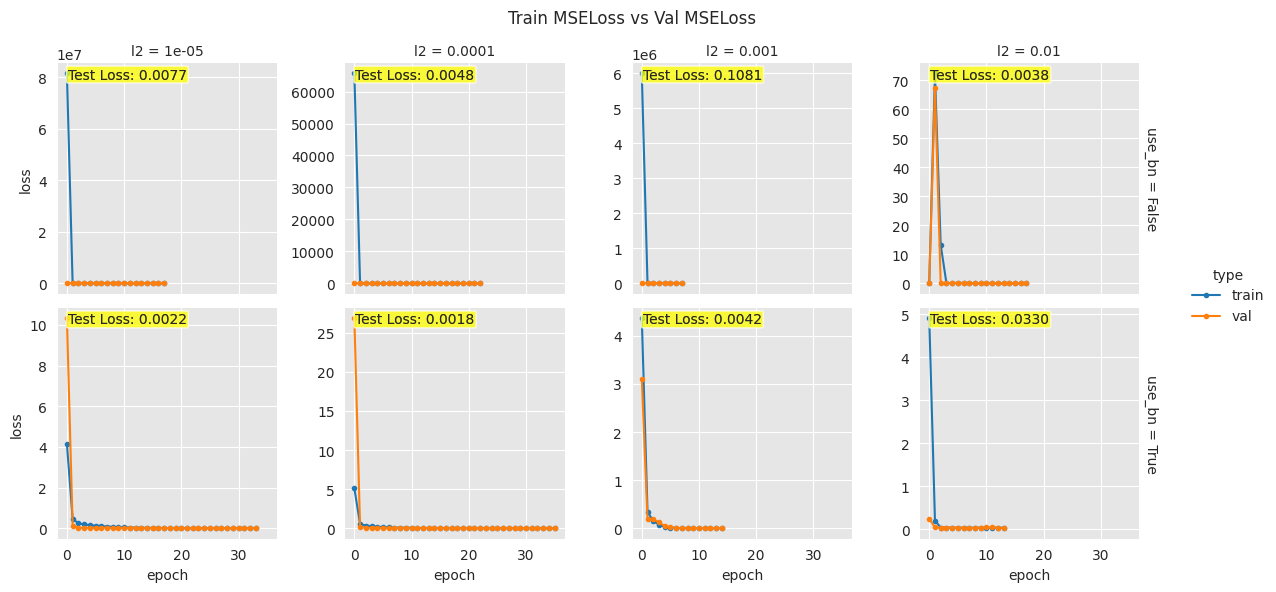

In [42]:
plot_loss_variation(var1, var2, exp403)

Experiment 404

- model_type : CNN
- Best performance: model_code(Depth2) / hid_dim(256)

In [43]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)


parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp404_test"

# ====== Model ====== #
args.model_type = 'CNN'
args.model_code = 'Depth2'
args.in_channels = 1
args.out_dim = 304 * 4
args.hid_dim = 256
args.act = 'relu'

# ====== Regularization ======= #
args.l2 = 0.0001
args.use_bn = False
args.dropout = 0.4

# ====== Optimizer & Training ====== #
args.optim = 'Adam' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0001
args.epoch = 100

args.use_early_stopping = True
args.use_scheduler = True

args.train_batch_size = 256
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'model_code'
name_var2 = 'hid_dim'
list_var1 = ['Depth1', 'Depth2', 'Depth3', 'Depth4']
list_var2 = [256, 512, 1024, 2048]

for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)

        setting, result = experiment(partition, deepcopy(args))
        hash_key =  save_exp_result(setting, result)

Namespace(exp_name='exp404_test', model_type='CNN', model_code='Depth1', in_channels=1, out_dim=1216, hid_dim=256, act='relu', l2=0.0001, use_bn=False, dropout=0.4, optim='Adam', lr=0.0001, epoch=100, use_early_stopping=True, use_scheduler=True, train_batch_size=256, test_batch_size=1024)
Epoch 0, Loss(train/val) 0.0226/0.0064, MAELoss(train/val) 0.1041/0.0607, MAE_origLoss(val) 5.8711. Took 1.12 sec, Current LR 0.000100
Epoch 1, Loss(train/val) 0.0048/0.0038, MAELoss(train/val) 0.0525/0.0467, MAE_origLoss(val) 4.5165. Took 0.68 sec, Current LR 0.000100
Epoch 2, Loss(train/val) 0.0036/0.0033, MAELoss(train/val) 0.0449/0.0434, MAE_origLoss(val) 4.1927. Took 0.68 sec, Current LR 0.000100
Epoch 3, Loss(train/val) 0.0032/0.0031, MAELoss(train/val) 0.0426/0.0416, MAE_origLoss(val) 4.0221. Took 0.69 sec, Current LR 0.000100
Epoch 4, Loss(train/val) 0.0030/0.0029, MAELoss(train/val) 0.0411/0.0403, MAE_origLoss(val) 3.8988. Took 0.69 sec, Current LR 0.000100
Epoch 5, Loss(train/val) 0.0029/0.0

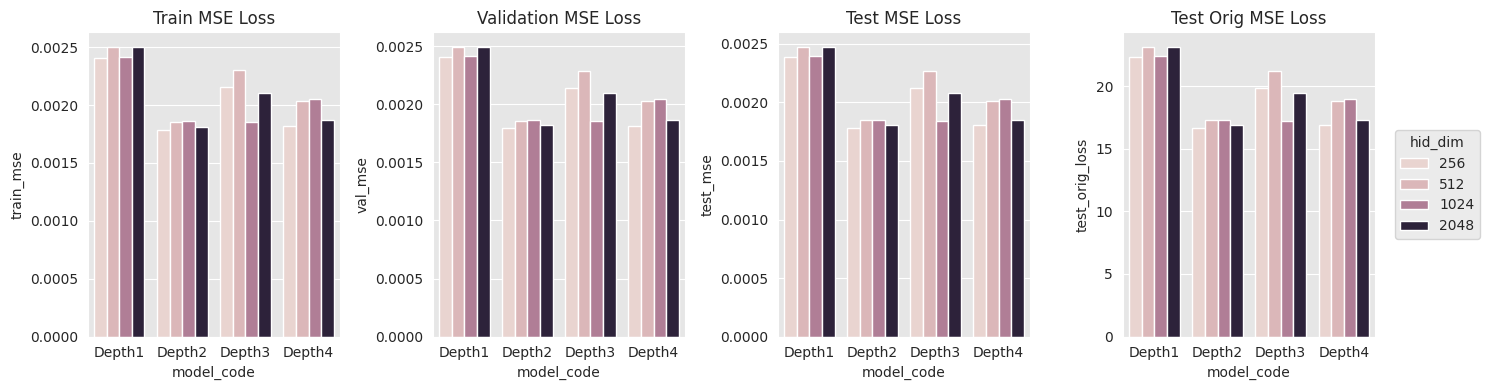

In [48]:
exp404 = load_exp_result('exp404')
var1 = name_var1
var2 = name_var2
plot_mse_loss(var1, var2, exp404, order=order)

In [52]:
df = exp404.copy()
df = df[df['hid_dim'] == 256]

order = ['Depth1', 'Depth2', 'Depth3', 'Depth4']
df['model_code'] = pd.Categorical(df['model_code'], categories=order, ordered=True)

df = df.sort_values(by='model_code')

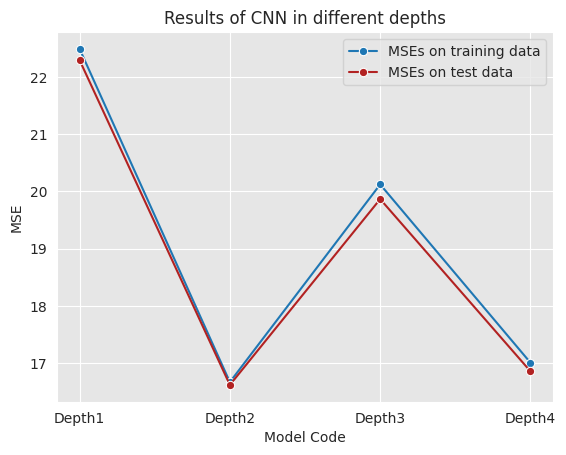

In [53]:
sns.lineplot(x='model_code', y='train_orig_loss', data=df[['model_code','train_orig_loss' , 'test_orig_loss']],  label='MSEs on training data', marker ='o')
sns.lineplot(x='model_code', y='test_orig_loss', data=df[['model_code','train_orig_loss' , 'test_orig_loss']],  label='MSEs on test data', marker = 'o', c = 'firebrick')
plt.legend()
plt.title('Results of CNN in different depths')
plt.xlabel('Model Code')
plt.ylabel('MSE')
plt.show()

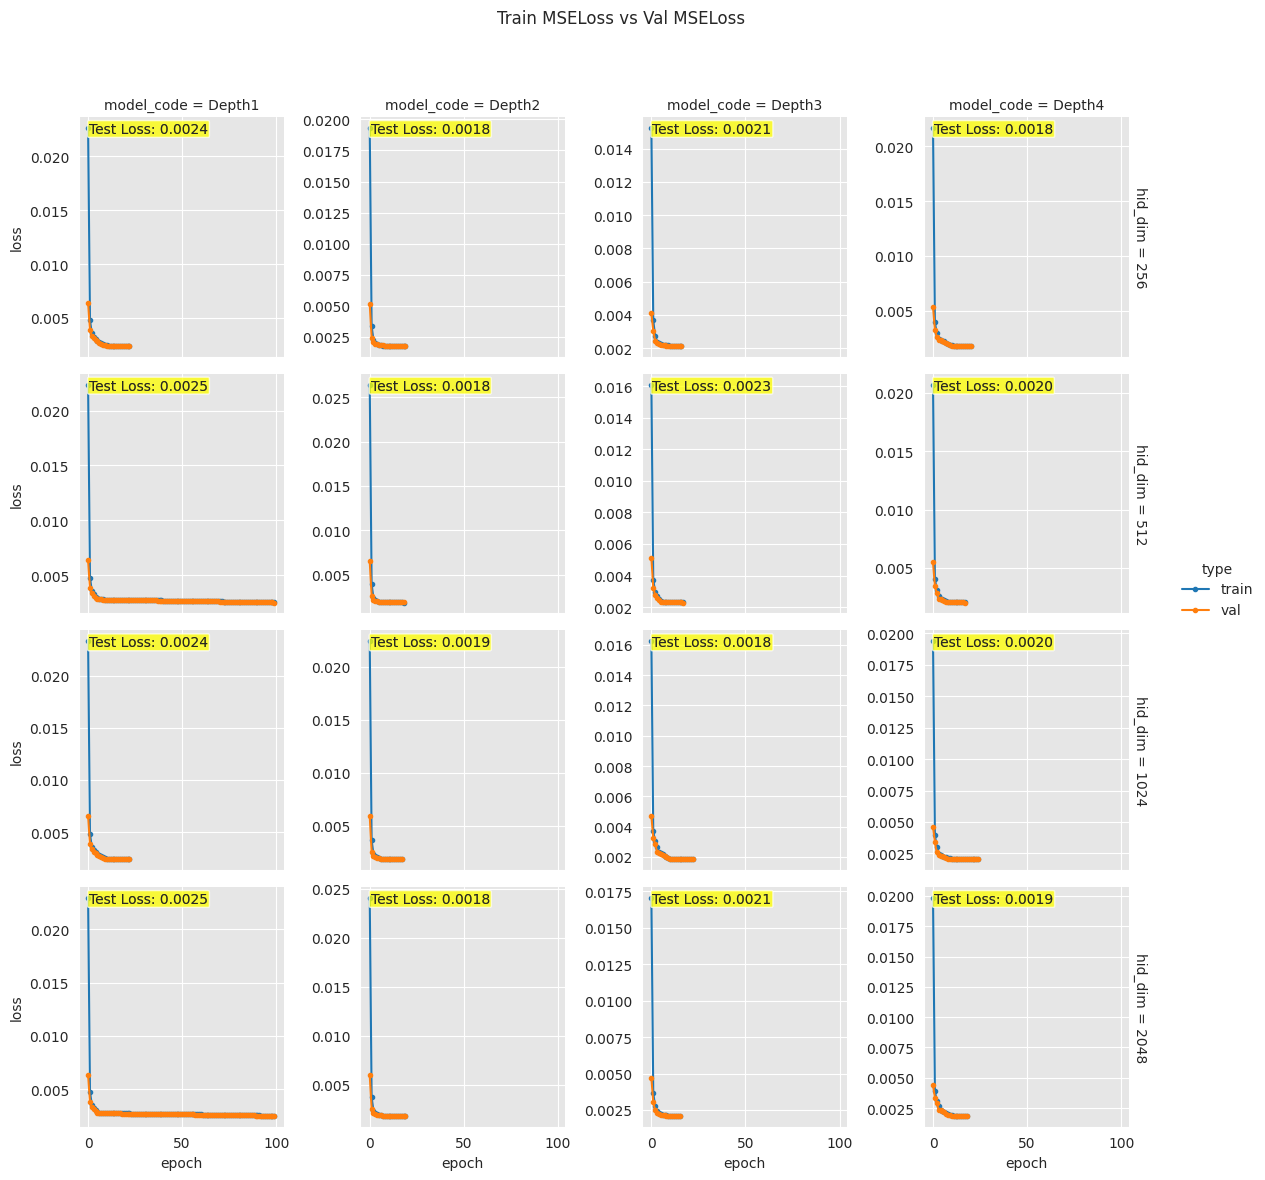

In [50]:
plot_loss_variation(var1, var2, exp404, order_var1=order)

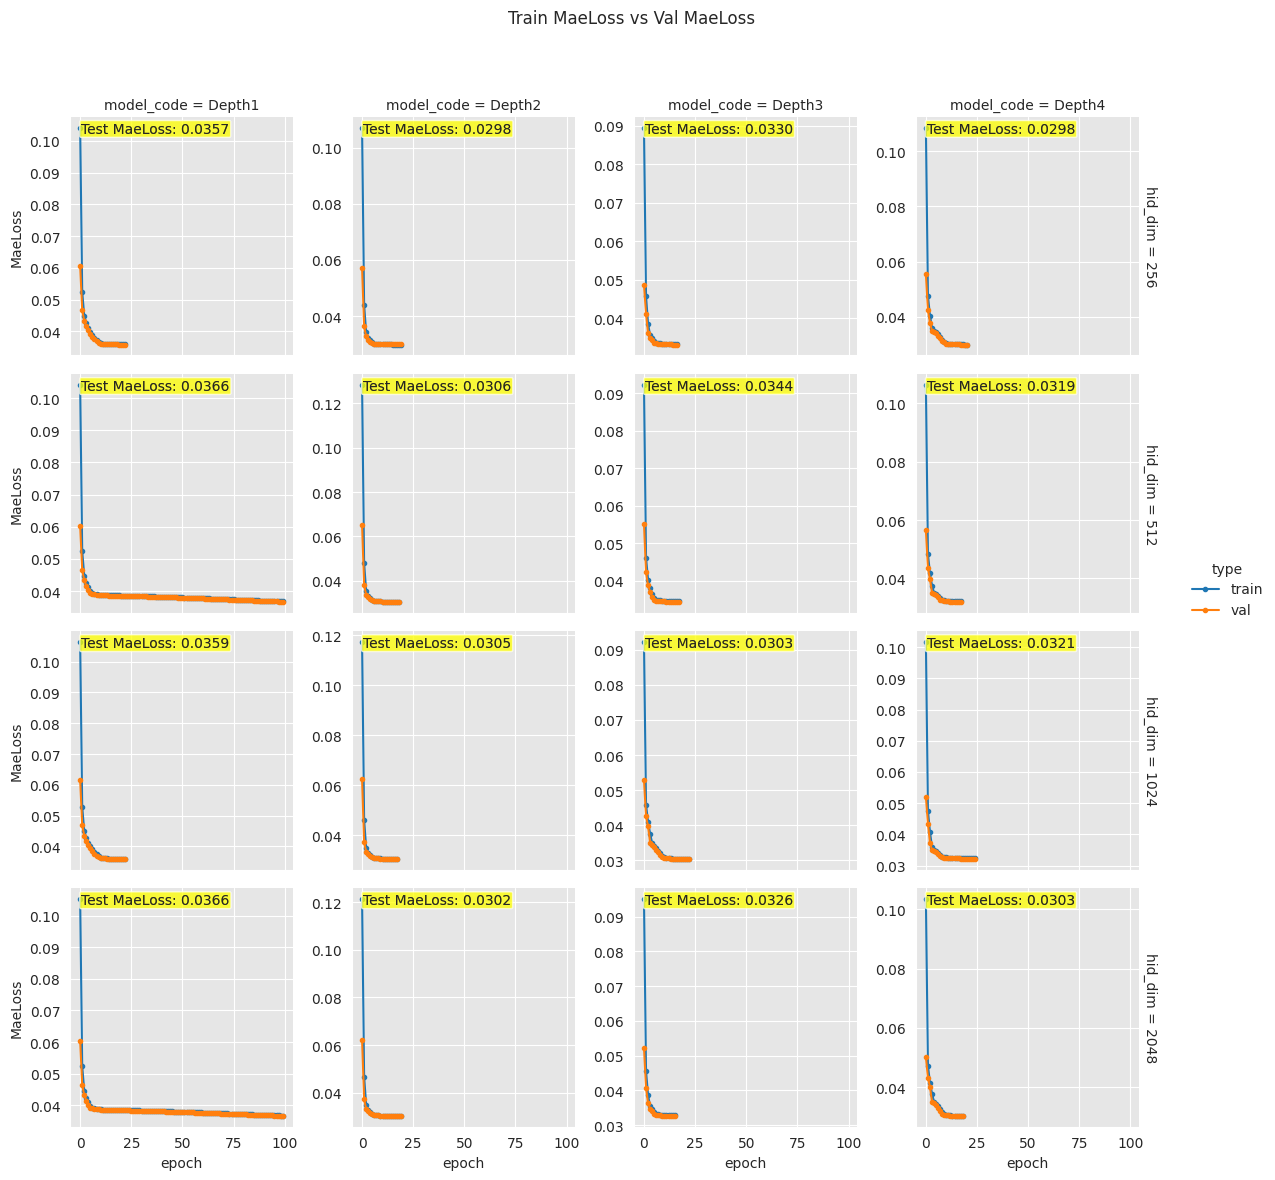

In [51]:
plot_mae_loss_variation(var1, var2, exp404, order_var1=order)

Experiment 405

- model_type : CNN
- Best performance : lr(0.0001), dropout(0.4)

In [54]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)


parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp405_test"  #

# ====== Model ====== #
args.model_type = 'CNN'
args.model_code = 'Depth2'
args.in_channels = 1
args.out_dim = 304 * 4
args.hid_dim = 256
args.act = 'relu'

# ====== Regularization ======= #
args.l2 = 0.0001
args.use_bn = False
args.dropout = 0.4

# ====== Optimizer & Training ====== #
args.optim = 'Adam' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0001
args.epoch = 100

args.use_early_stopping = True
args.use_scheduler = True

args.train_batch_size = 256
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'lr'
name_var2 = 'dropout'
list_var1 = [0.01, 0.001, 0.0001]
list_var2 = [0.2, 0.3, 0.4]

for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)

        setting, result = experiment(partition, deepcopy(args))
        hash_key =  save_exp_result(setting, result)

Namespace(exp_name='exp405_test', model_type='CNN', model_code='Depth2', in_channels=1, out_dim=1216, hid_dim=256, act='relu', l2=0.0001, use_bn=False, dropout=0.2, optim='Adam', lr=0.01, epoch=100, use_early_stopping=True, use_scheduler=True, train_batch_size=256, test_batch_size=1024)
Epoch 0, Loss(train/val) 232.3715/3.1787, MAELoss(train/val) 9.8636/1.6269, MAE_origLoss(val) 157.2639. Took 2.10 sec, Current LR 0.010000
Epoch 1, Loss(train/val) 0.4792/0.0644, MAELoss(train/val) 0.4734/0.1991, MAE_origLoss(val) 19.2464. Took 1.65 sec, Current LR 0.010000
Epoch 2, Loss(train/val) 0.0521/0.0428, MAELoss(train/val) 0.1884/0.1684, MAE_origLoss(val) 16.2785. Took 1.62 sec, Current LR 0.010000
Epoch 3, Loss(train/val) 0.0301/0.0224, MAELoss(train/val) 0.1391/0.1079, MAE_origLoss(val) 10.4320. Took 1.74 sec, Current LR 0.010000
Epoch 4, Loss(train/val) 0.0183/0.0174, MAELoss(train/val) 0.1028/0.0924, MAE_origLoss(val) 8.9360. Took 1.70 sec, Current LR 0.010000
Epoch 5, Loss(train/val) 0.011

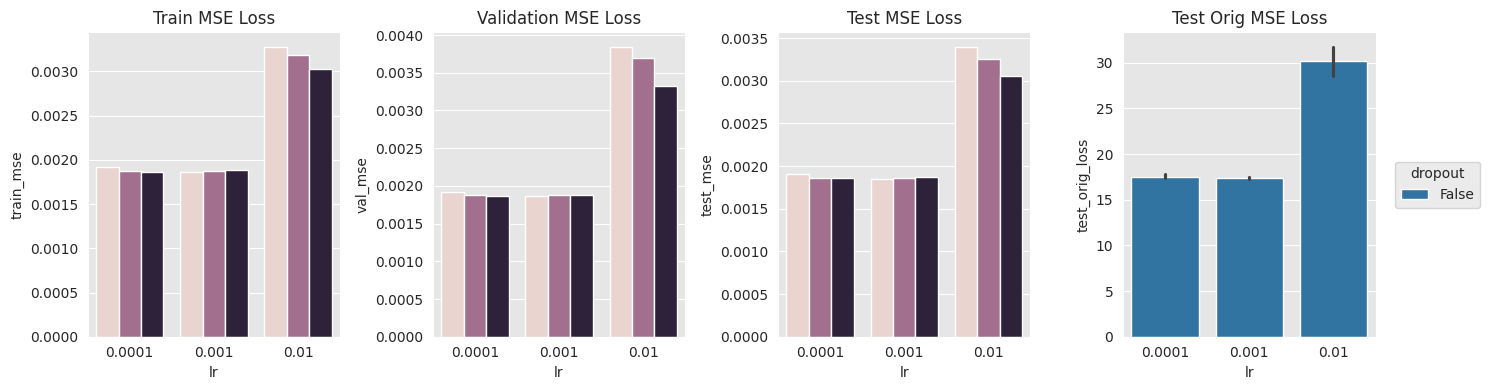

In [63]:
exp405 = load_exp_result('exp405')
var1 = 'lr'
var2 = 'dropout'
plot_mse_loss(var1, var2, exp405)

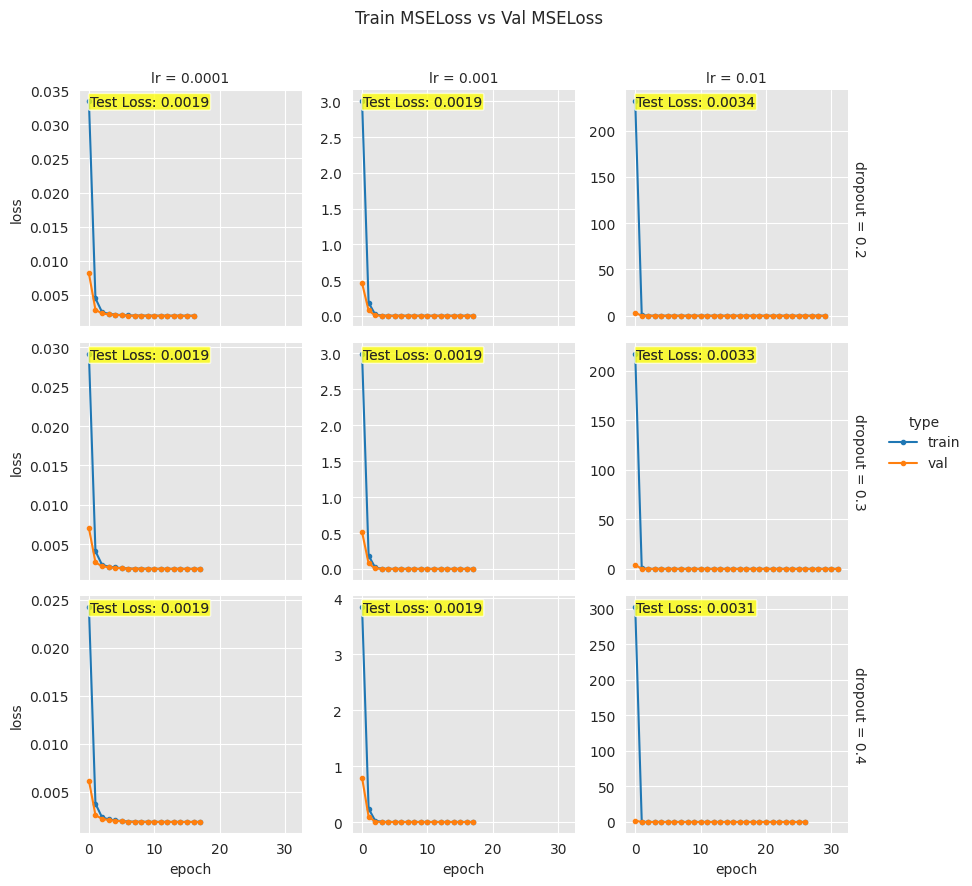

In [64]:
plot_loss_variation(var1, var2, exp405)

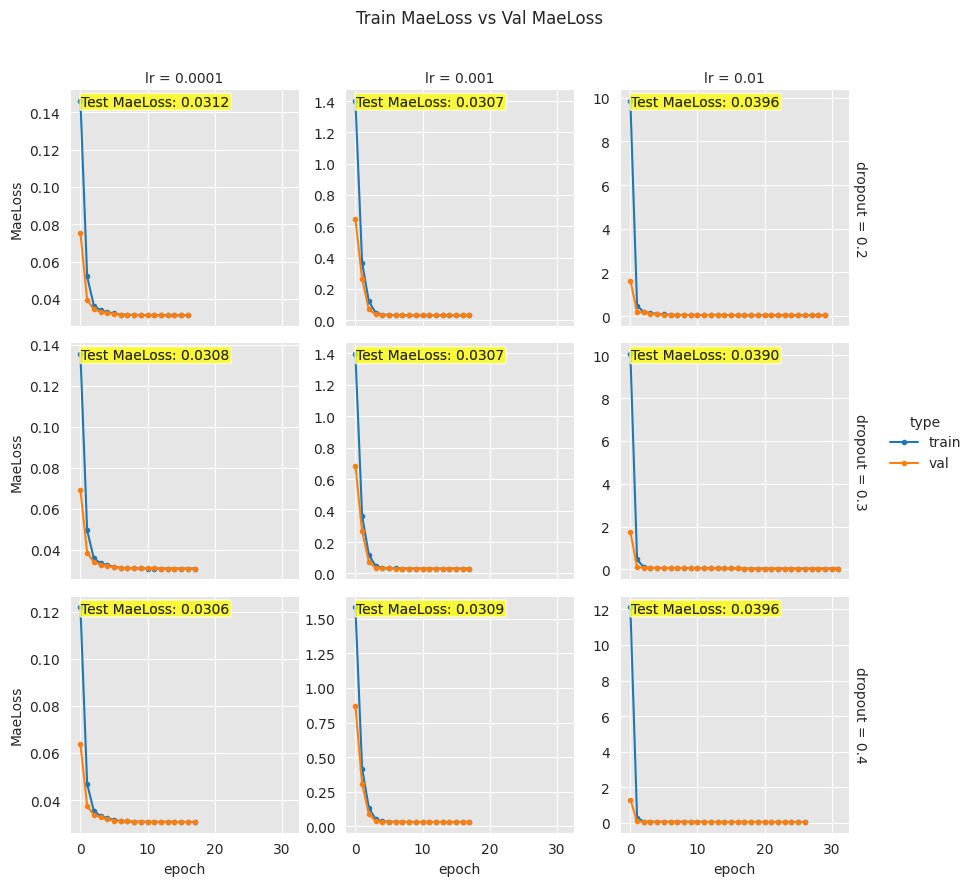

In [66]:
plot_mae_loss_variation(var1, var2, exp405)

Experiment 406

- model_type : CNN
- Best performance : l2(0.1) / use_bn(True)

In [58]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)


parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp406_test"

# ====== Model ====== #
args.model_type = 'CNN'
args.model_code = 'Depth2'
args.in_channels = 1
args.out_dim = 304 * 4
args.hid_dim = 256
args.act = 'relu'

# ====== Regularization ======= #
args.l2 = 0.0001
args.use_bn = False
args.dropout = 0.4

# ====== Optimizer & Training ====== #
args.optim = 'Adam' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0001
args.epoch = 100

args.use_early_stopping = True
args.use_scheduler = True

args.train_batch_size = 256
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'l2'
name_var2 = 'use_bn'
list_var1 = [0.1, 0.01, 0.001, 0.0001]
list_var2 = [True, False]

for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)

        setting, result = experiment(partition, deepcopy(args))
        hash_key =  save_exp_result(setting, result)

Namespace(exp_name='exp406_test', model_type='CNN', model_code='Depth2', in_channels=1, out_dim=1216, hid_dim=256, act='relu', l2=0.1, use_bn=True, dropout=0.4, optim='Adam', lr=0.0001, epoch=100, use_early_stopping=True, use_scheduler=True, train_batch_size=256, test_batch_size=1024)
Epoch 0, Loss(train/val) 0.6195/0.0770, MAELoss(train/val) 0.6236/0.2399, MAE_origLoss(val) 23.1894. Took 2.11 sec, Current LR 0.000100
Epoch 1, Loss(train/val) 0.0570/0.0213, MAELoss(train/val) 0.1906/0.1163, MAE_origLoss(val) 11.2470. Took 1.77 sec, Current LR 0.000100
Epoch 2, Loss(train/val) 0.0125/0.0075, MAELoss(train/val) 0.0872/0.0673, MAE_origLoss(val) 6.5042. Took 1.86 sec, Current LR 0.000100
Epoch 3, Loss(train/val) 0.0062/0.0048, MAELoss(train/val) 0.0606/0.0533, MAE_origLoss(val) 5.1527. Took 2.02 sec, Current LR 0.000100
Epoch 4, Loss(train/val) 0.0040/0.0034, MAELoss(train/val) 0.0487/0.0447, MAE_origLoss(val) 4.3170. Took 1.86 sec, Current LR 0.000100
Epoch 5, Loss(train/val) 0.0031/0.002

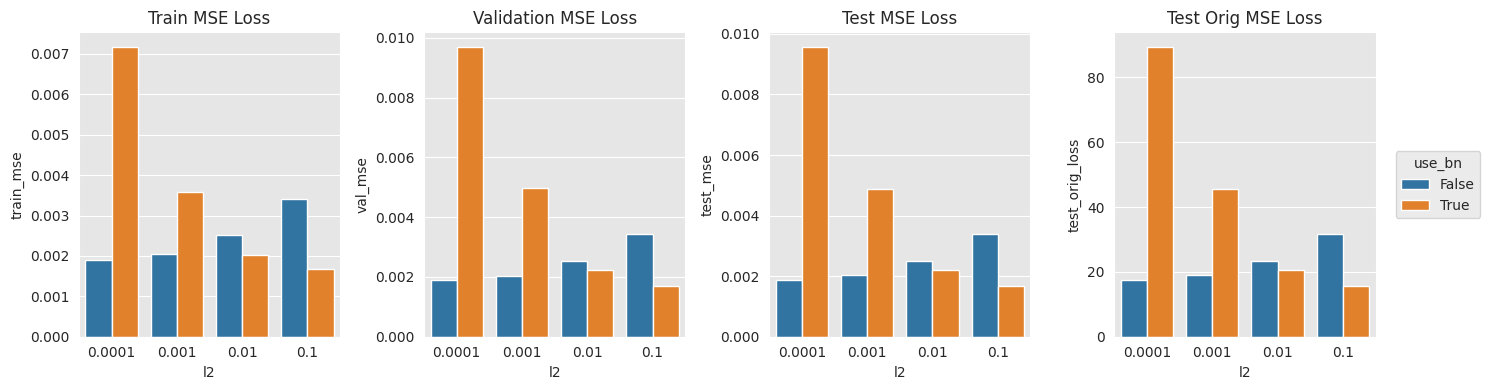

In [67]:
exp406 = load_exp_result('exp406')
var1 = name_var1
var2 = name_var2
plot_mse_loss(var1, var2, exp406)

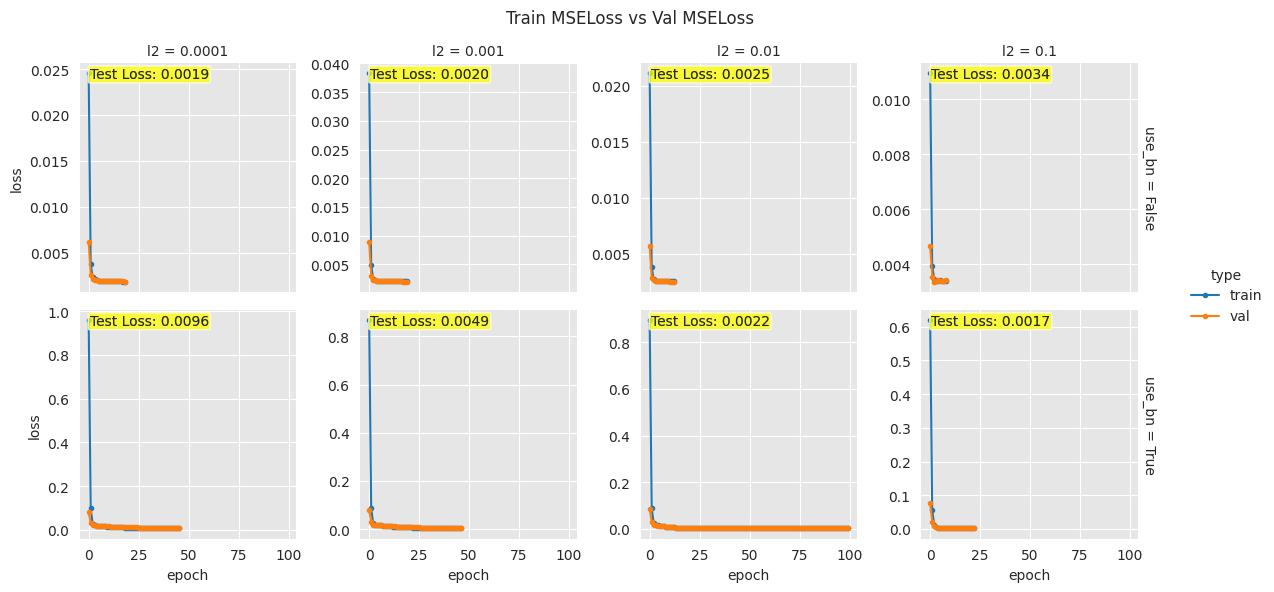

In [68]:
plot_loss_variation(var1, var2, exp406)

Best MLP vs Best CNN

json(pth) 로컬에 저장
저장된 파일 불러오기

In [ ]:
# results 폴더 만들기
os.makedirs('./results', exist_ok=True)

In [ ]:
from google.colab import files
uploaded = files.upload()

for filename in uploaded.keys():
    os.rename(filename, f'./results/{filename}')

In [ ]:
'''
uploaded = files.upload()

#os.makedirs('./checkpoints', exist_ok=True)

for filename in uploaded.keys():
    os.rename(filename, f'./checkpoints/{filename}')
'''

In [69]:
result_concat = pd.concat([exp403.loc[exp403['test_mse'].idxmin()], exp406.loc[exp406['test_mse'].idxmin()]], axis=1)
result_concat.T

,train_losses,val_losses,train_mae_losses,val_mae_losses,val_mae_orig_losses,train_mse,val_mse,test_mse,train_mae,val_mae,...,dropout,optim,lr,use_early_stopping,use_scheduler,train_batch_size,test_batch_size,hash_key,model_code,in_channels
1,"[5.107210516505359, 0.5186987237175694, 0.3455...","[26.835758209228516, 0.14766360819339752, 0.06...","[1.370532196940738, 0.5616492033892763, 0.4610...","[3.3738842010498047, 0.32233989238739014, 0.19...","[326.1452941894531, 31.159835815429688, 19.333...",0.003439,0.001805,0.001784,0.043276,0.029605,...,0.2,Adam,0.01,True,True,256,1024,cce0b5,NaN,NaN
4,"[0.6195269047651558, 0.0569601207536822, 0.012...","[0.07700429111719131, 0.021344425156712532, 0....","[0.623620088665597, 0.1906115950027102, 0.0872...","[0.2398841679096222, 0.11634786427021027, 0.06...","[23.189416885375977, 11.246999740600586, 6.504...",0.001673,0.001687,0.001675,0.02911,0.029184,...,0.4,Adam,0.0001,True,True,256,1024,b8f35e,Depth2,1


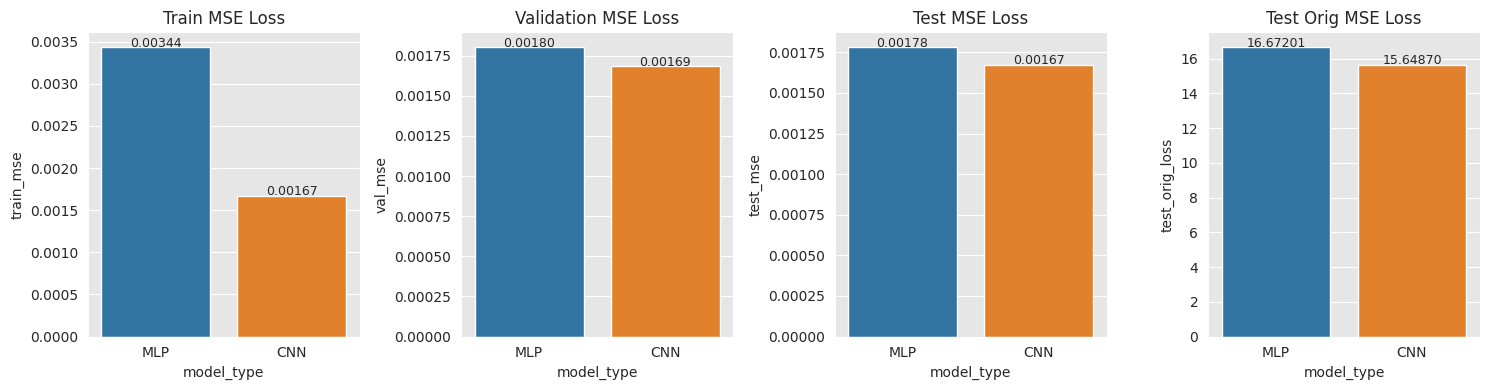

In [71]:
fig, ax = plt.subplots(1, 4)
fig.set_size_inches(15, 4)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

bar0  = sns.barplot(x='model_type', y='train_mse', hue='model_type', data=result_concat.T, ax=ax[0])
bar1 =  sns.barplot(x='model_type', y='val_mse', hue='model_type', data=result_concat.T, ax=ax[1])
bar2 = sns.barplot(x='model_type', y='test_mse', hue='model_type', data=result_concat.T, ax=ax[2])
bar3 = sns.barplot(x='model_type', y='test_orig_loss', hue='model_type', data=result_concat.T, ax=ax[3])

titles = ['Train MSE Loss', 'Validation MSE Loss', 'Test MSE Loss', 'Test Orig MSE Loss']

for i, bar in enumerate([bar0, bar1, bar2, bar3]):
    ax[i].set_title(titles[i])
    for container in bar.containers:
        ax[i].bar_label(container, fmt='%.5f', label_type='edge', padding=-2, fontsize=9)

plt.tight_layout()
plt.show()

# Predict

In [72]:
def predict_best_model_1(partition, exp_name) :

  df_results = load_exp_result(exp_name)
  best_row = df_results.loc[df_results['test_mse'].idxmin()]
  args = argparse.Namespace(**best_row.to_dict())


  test_loader = torch.utils.data.DataLoader(partition['test'], batch_size = args.test_batch_size, shuffle=False)
  predictions = []
  targets = []

  sample_inputs, _ = next(iter(test_loader))    # 1번째 미니 배치 추출
  sample_inputs = sample_inputs.cuda()
  in_shape = sample_inputs.shape



  # 모델 초기화
  if best_row.model_type == 'CNN':
      net = CNN(model_code = args.model_code,
                in_channels = args.in_channels,
                out_dim = args.out_dim,
                act=args.act,
                use_bn=args.use_bn,
                dropout=args.dropout,
                hid_dim=args.hid_dim)


  elif best_row.model_type == 'MLP':

      net = MLP(in_shape=in_shape,
                out_dim=args.out_dim,
                hid_dim=args.hid_dim,
                n_layer=args.n_layer,
                act=args.act,
                dropout=args.dropout,
                use_bn=args.use_bn
              )


  net.cuda()



  # 저장된 best 모델 로드
  hash_key = best_row['hash_key']
  exp_name = best_row['exp_name']
  model_path = f'./checkpoints/{exp_name}-{hash_key}.pth'
  net.load_state_dict(torch.load(model_path))
  net.eval()



  with torch.no_grad():
      for inputs, labels in test_loader:
          inputs = inputs.cuda()
          labels = labels.cuda()

          outputs = net(inputs)

          predictions.append(outputs.detach().cpu())
          targets.append(labels.detach().cpu())

  y_pred = torch.cat(predictions, dim=0).numpy()
  y_true = torch.cat(targets, dim=0).numpy()

  return y_pred, y_true

Prediction via MLP

In [73]:
y_pred_mlp, y_true_mlp = predict_best_model_1(partition, 'exp403')

In [76]:
np.mean((y_pred_original - y_true_original)**2)

np.float32(16.618084)

In [75]:
y_pred_original = y_scaler.inverse_transform(y_pred_mlp.reshape(-1, 4)).reshape(y_pred_mlp.shape)
y_true_original = y_scaler.inverse_transform(y_true_mlp.reshape(-1, 4)).reshape(y_true_mlp.shape)

In [77]:
selected_pred = y_pred_original[:, 0, :, -1]
selected_true = y_true_original[:, 0, :, -1]

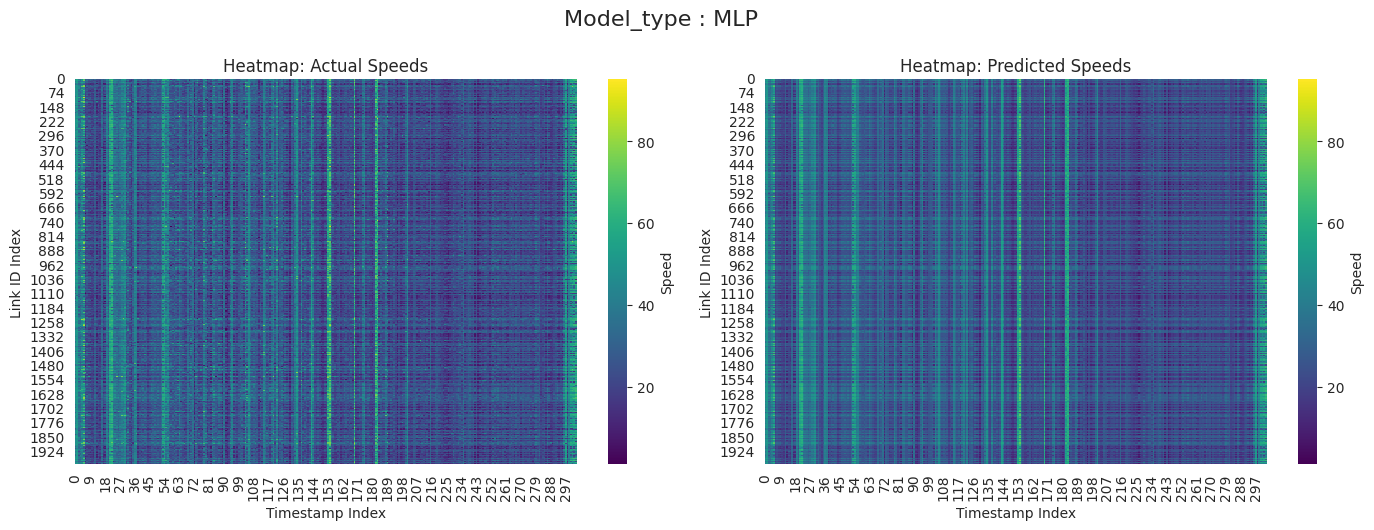

In [78]:
fig, ax = plt.subplots(1, 2, figsize=(17, 5))

vmin = min(selected_true.min(), selected_pred.min())
vmax = max(selected_true.max(), selected_pred.max())

sns.heatmap(selected_true, ax=ax[0], cmap='viridis', cbar_kws={'label': 'Speed'}, vmin=vmin, vmax=vmax)
ax[0].set_title('Heatmap: Actual Speeds')
ax[0].set_xlabel('Timestamp Index')
ax[0].set_ylabel('Link ID Index')

sns.heatmap(selected_pred, ax=ax[1], cmap='viridis', cbar_kws={'label': 'Speed'}, vmin=vmin, vmax=vmax)
ax[1].set_title('Heatmap: Predicted Speeds')
ax[1].set_xlabel('Timestamp Index')
ax[1].set_ylabel('Link ID Index')

plt.suptitle('Model_type : MLP', fontsize=16, x=0.47, y=1.02)
plt.subplots_adjust(wspace=0.1)

Prediction via CNN

In [79]:
y_pred_cnn, y_true_cnn = predict_best_model_1(partition, 'exp406')

In [80]:
y_pred_original = y_scaler.inverse_transform(y_pred_cnn.reshape(-1, 4)).reshape(y_pred_cnn.shape)
y_true_original = y_scaler.inverse_transform(y_true_cnn.reshape(-1, 4)).reshape(y_true_cnn.shape)

In [81]:
np.mean((y_pred_original - y_true_original)**2)

np.float32(15.634759)

In [82]:
selected_pred = y_pred_original[:, 0, :, -1]
selected_true = y_true_original[:, 0, :, -1]

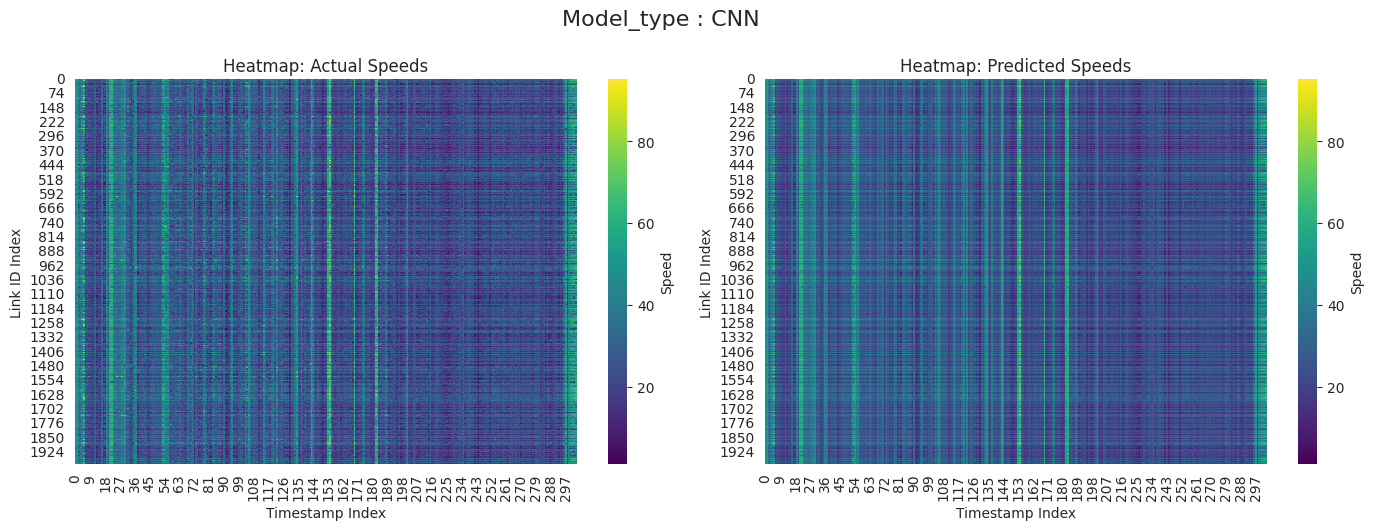

In [83]:
fig, ax = plt.subplots(1, 2, figsize=(17, 5))

vmin = min(selected_true.min(), selected_pred.min())
vmax = max(selected_true.max(), selected_pred.max())

sns.heatmap(selected_true, ax=ax[0], cmap='viridis', cbar_kws={'label': 'Speed'}, vmin=vmin, vmax=vmax)
ax[0].set_title('Heatmap: Actual Speeds')
ax[0].set_xlabel('Timestamp Index')
ax[0].set_ylabel('Link ID Index')

sns.heatmap(selected_pred, ax=ax[1], cmap='viridis', cbar_kws={'label': 'Speed'}, vmin=vmin, vmax=vmax)
ax[1].set_title('Heatmap: Predicted Speeds')
ax[1].set_xlabel('Timestamp Index')
ax[1].set_ylabel('Link ID Index')

plt.suptitle('Model_type : CNN', fontsize=16, x=0.47, y=1.02)
plt.subplots_adjust(wspace=0.1)